In [54]:
import os
import re
import time
import json
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from dotenv import load_dotenv
from IPython.display import display, Markdown, HTML
from wordcloud import WordCloud

# TensorFlow dan Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD

# Transformers dan HuggingFace
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
    BertTokenizer,
    BertForSequenceClassification,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    XLNetTokenizer,
    XLNetForSequenceClassification,
)
from huggingface_hub import InferenceClient

# Google API
from googleapiclient.discovery import build
import google.generativeai as genai

# Disable warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Download NLTK resources
print("Downloading NLTK resources...")
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
stop_words = set(stopwords.words("indonesian"))

# Pandas & Matplotlib settings
pd.set_option("display.max_colwidth", 100)
plt.style.use("seaborn-v0_8-whitegrid")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

print("✅ All required libraries imported successfully")
print("✅ NLTK resources downloaded successfully")


✅ All required libraries imported successfully
✅ NLTK resources downloaded successfully


In [28]:
# === Initialize logger ===
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

# === Gemini API setup ===
GEMINI_API_KEYS = [
    v for k, v in os.environ.items()
    if k.startswith("GEMINI_API_KEY_") and v
]
if not GEMINI_API_KEYS:
    GEMINI_API_KEYS = [
        input(f"Enter Gemini API Key #{i+1}: ")
        for i in range(5)
    ]

# Konfigurasi model Gemini
models = [genai.GenerativeModel('gemini-2.0-flash') for _ in GEMINI_API_KEYS]
for api_key, model in zip(GEMINI_API_KEYS, models):
    genai.configure(api_key=api_key)

# === YouTube API setup ===
YOUTUBE_API_KEY = os.getenv('YOUTUBE_API_KEY') or input("Enter your YouTube API Key: ")
VIDEO_ID        = os.getenv('VIDEO_ID')        or input("Enter the YouTube Video ID: ")

# === Hugging Face API setup ===
HF_API_KEYS = [
    v for k, v in os.environ.items()
    if k.startswith("HF_API_KEY_") and v
]
if not HF_API_KEYS:
    HF_API_KEYS = [
        input(f"Enter Hugging Face API Key #{i+1}: ")
        for i in range(3)
    ]

# Inisialisasi client Hugging Face
hf_clients = [InferenceClient(token=api_key) for api_key in HF_API_KEYS]

# === Output directory setup ===
BASE_OUTPUT = os.getenv('OUTPUT_DIR', './output')

STAGES = {
    '01_comments_collection':     None,
    '02_preprocessing':           None,
    '03_eda':                     None,
    '04_clustering':              None,
    '05_sentiment':               None,
    '06_transformer_comparison':  None,
    '07_advanced_insights':       None
}

subdirs = {}
for stage in STAGES:
    stage_path = os.path.join(BASE_OUTPUT, stage)
    os.makedirs(stage_path, exist_ok=True)
    subdirs[stage] = {}
    for sub in ('analisis', 'visualisasi'):
        path = os.path.join(stage_path, sub)
        os.makedirs(path, exist_ok=True)
        subdirs[stage][sub] = path

# === Logging initialized structure ===
logger.info("Directory structure initialized under %s", BASE_OUTPUT)
for stage, subs in subdirs.items():
    logger.info("Stage %-25s:", stage)
    for name, path in subs.items():
        logger.info("  - %-12s -> %s", name, path)

2025-05-08 05:54:21 INFO Directory structure initialized under ./output
2025-05-08 05:54:21 INFO Stage 01_comments_collection   :
2025-05-08 05:54:21 INFO   - analisis     -> ./output/01_comments_collection/analisis
2025-05-08 05:54:21 INFO   - visualisasi  -> ./output/01_comments_collection/visualisasi
2025-05-08 05:54:21 INFO Stage 02_preprocessing         :
2025-05-08 05:54:21 INFO   - analisis     -> ./output/02_preprocessing/analisis
2025-05-08 05:54:21 INFO   - visualisasi  -> ./output/02_preprocessing/visualisasi
2025-05-08 05:54:21 INFO Stage 03_eda                   :
2025-05-08 05:54:21 INFO   - analisis     -> ./output/03_eda/analisis
2025-05-08 05:54:21 INFO   - visualisasi  -> ./output/03_eda/visualisasi
2025-05-08 05:54:21 INFO Stage 04_clustering            :
2025-05-08 05:54:21 INFO   - analisis     -> ./output/04_clustering/analisis
2025-05-08 05:54:21 INFO   - visualisasi  -> ./output/04_clustering/visualisasi
2025-05-08 05:54:21 INFO Stage 05_sentiment             :


In [6]:
# Ambil direktori dari subdirs yang sudah dibuat sebelumnya
COMMENTS_DIR = subdirs['01_comments_collection']['analisis']
VISUALS_DIR  = subdirs['01_comments_collection']['visualisasi']

def get_youtube_comments(video_id: str, api_key: str) -> pd.DataFrame:
    client = build("youtube", "v3", developerKey=api_key)
    comments = []
    request = client.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=100,
        textFormat="plainText"
    )
    with tqdm(desc="Fetching comments", unit="comment") as pbar:
        while request:
            response = request.execute()
            for item in response.get("items", []):
                s = item["snippet"]["topLevelComment"]["snippet"]
                comments.append({
                    "comment_id":   item["id"],
                    "author":       s.get("authorDisplayName"),
                    "text":         s.get("textDisplay"),
                    "published_at": s.get("publishedAt"),
                    "like_count":   s.get("likeCount", 0)
                })
                pbar.update(1)
            request = client.commentThreads().list_next(request, response)

    df = pd.DataFrame(comments)
    logger.info("Retrieved %d comments", len(df))
    return df

logger.info("Starting YouTube comment collection for video %s", VIDEO_ID)
df_comments = get_youtube_comments(VIDEO_ID, YOUTUBE_API_KEY)

# Simpan data
csv_path = os.path.join(COMMENTS_DIR, "comments_raw.csv")
df_comments.to_csv(csv_path, index=False)
logger.info("Saved raw comments to %s", csv_path)

# Tampilkan sample
display(Markdown("### Sample of Collected Comments"))
display(df_comments.head())

2025-05-08 05:18:03 INFO Starting YouTube comment collection for video -WLpXmnBmxo


2025-05-08 05:18:03 INFO file_cache is only supported with oauth2client<4.0.0


Fetching comments: 0comment [00:00, ?comment/s]

2025-05-08 05:18:15 INFO Retrieved 10404 comments
2025-05-08 05:18:16 INFO Saved raw comments to ./output/01_comments_collection/analisis/comments_raw.csv


### Sample of Collected Comments

,comment_id,author,text,published_at,like_count
0,UgxGj_4fD-U2hgHAvlB4AaABAg,@NjiAhmad-x8m,Ngelihat komen masih banyak yg sadar ternyata,2025-05-07T20:50:57Z,0
1,UgyagarwqGdjRiuahbF4AaABAg,@nikozio4981,"Krain maung, Ternyata meow..\nJawaban ga ada yg di jwb",2025-05-07T15:59:39Z,0
2,Ugz8Chl5ZOmr-hBmmVV4AaABAg,@Beeyourrselff,"Pak prabowo jangan ketularan wakilnya dong, 3 jam ngulang2 bener2 ujian buat saya.",2025-05-07T14:00:17Z,0
3,UgxjYX04V6EjtioNoW54AaABAg,@fahreeladjie2738,"Dari pandangan saya dan pendapat pribadi saya presiden ini dia gak liat fakta di lapangan , beli...",2025-05-07T10:56:28Z,0
4,UgxoLv9oxg7hm8aU5WN4AaABAg,@HaikalrfD8,"Baru aja ngeklik, udh ngantuk aja",2025-05-07T09:53:36Z,1


In [7]:
PREPROCESS_DIR = subdirs['02_preprocessing']['analisis']
VISUAL_DIR      = subdirs['02_preprocessing']['visualisasi']
os.makedirs(PREPROCESS_DIR, exist_ok=True)
os.makedirs(VISUAL_DIR, exist_ok=True)

df = df_comments.copy()

missing = df.isnull().sum()
percent = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'missing_values': missing, 'percentage': percent})
display(missing_df)

df = df.dropna(subset=['text'])
stop_words = set(stopwords.words('indonesian'))

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'<.*?>|http\S+|www\.\S+|https\S+|[^\w\s]|\d+', ' ', text)
    tokens = word_tokenize(text)
    return ' '.join(w for w in tokens if w not in stop_words and len(w) > 2)

df['cleaned_text'] = df['text'].apply(clean_text)
df = df[df['cleaned_text'].str.strip() != '']

df['original_length'] = df['text'].str.len()
df['cleaned_length']  = df['cleaned_text'].str.len()
df['word_count']      = df['cleaned_text'].str.split().str.len()

stats = df[['original_length', 'cleaned_length', 'word_count']].describe()
display(stats)

preprocessed_path = os.path.join(PREPROCESS_DIR, 'preprocessed_comments.csv')
df.to_csv(preprocessed_path, index=False)

display(df[['text', 'cleaned_text', 'word_count']].head())


,missing_values,percentage
comment_id,0,0.0
author,0,0.0
text,0,0.0
published_at,0,0.0
like_count,0,0.0


,original_length,cleaned_length,word_count
count,10148.000000,10148.000000,10148.000000
mean,117.326862,70.881356,10.016456
std,178.704247,103.506321,13.664821
min,3.000000,3.000000,1.000000
25%,34.000000,21.000000,3.000000
50%,67.000000,41.000000,6.000000
75%,134.000000,82.000000,12.000000
max,5856.000000,2751.000000,339.000000


,text,cleaned_text,word_count
0,Ngelihat komen masih banyak yg sadar ternyata,ngelihat komen sadar,3
1,"Krain maung, Ternyata meow..\nJawaban ga ada yg di jwb",krain maung meow jwb,4
2,"Pak prabowo jangan ketularan wakilnya dong, 3 jam ngulang2 bener2 ujian buat saya.",prabowo ketularan wakilnya jam ngulang bener ujian,7
3,"Dari pandangan saya dan pendapat pribadi saya presiden ini dia gak liat fakta di lapangan , beli...",pandangan pendapat pribadi presiden gak liat fakta lapangan beliau keknya liat nya data dikasih ...,28
4,"Baru aja ngeklik, udh ngantuk aja",aja ngeklik udh ngantuk aja,5


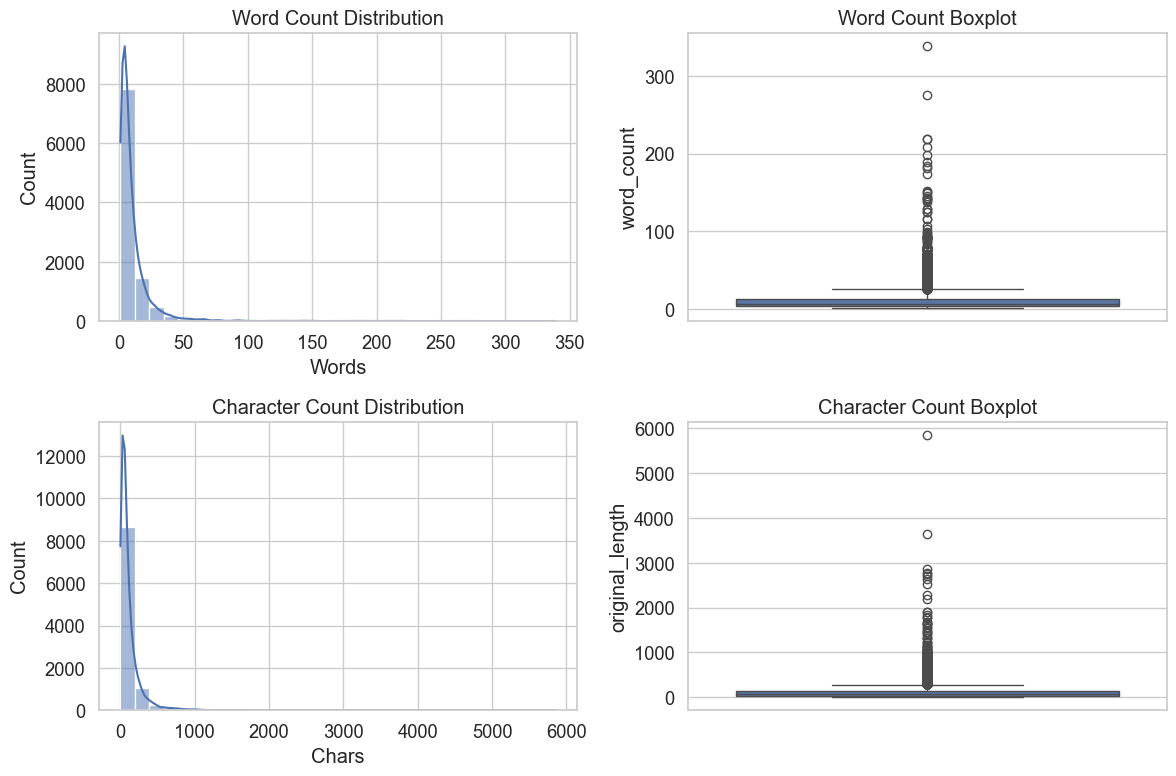

,text,word_count
7983,"Saya nonton full 3 jam dan saya salut dengan Pak Presiden yang mau membuat acara seperti ini, ma...",339
7051,Ini adalah ringkasan yang dibuat oleh AI. Mungkin ada ketidakakuratan.\n\nDurasi 00:00:00 - 01:0...,276
8855,Analisis Kritis terhadap Gagasan Politik-Ekonomi Presiden Prabowo dalam wawancara ini: \n\n1. Pr...,219
7007,"Rekomendasi nonton minimal 1,5x\r\n\r\n28:40 P1 Alfito Deannova (DetikCom)\r\n\r\n29:17 Mulai Ja...",219
8956,"pertanyaan 150 hari pencapaian:\nawal-awal tidak dicatat.\n\n9:07: ""saya laksanakan keyakinan sa...",208


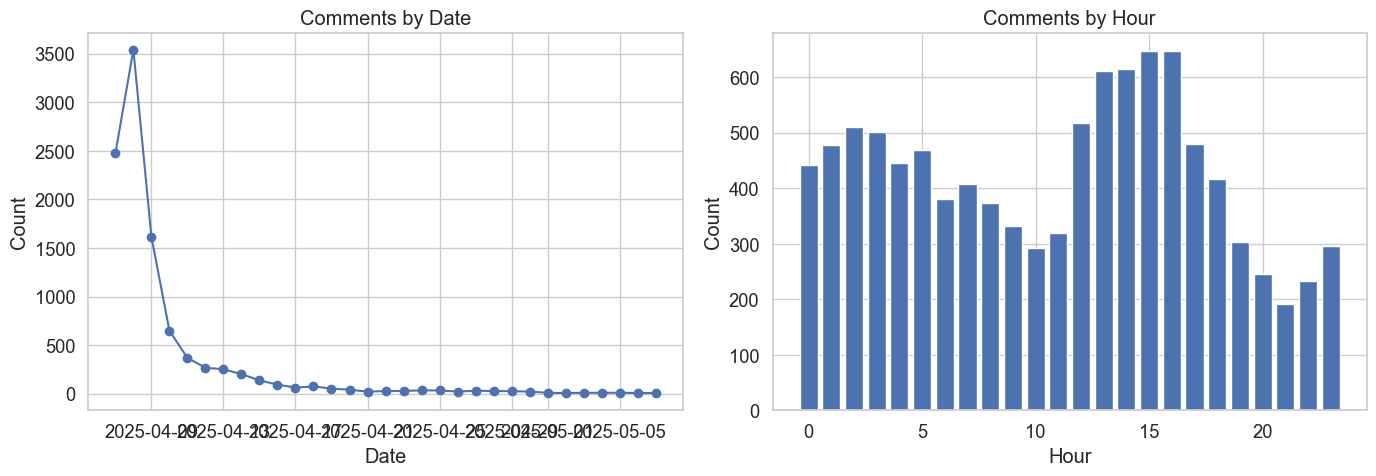

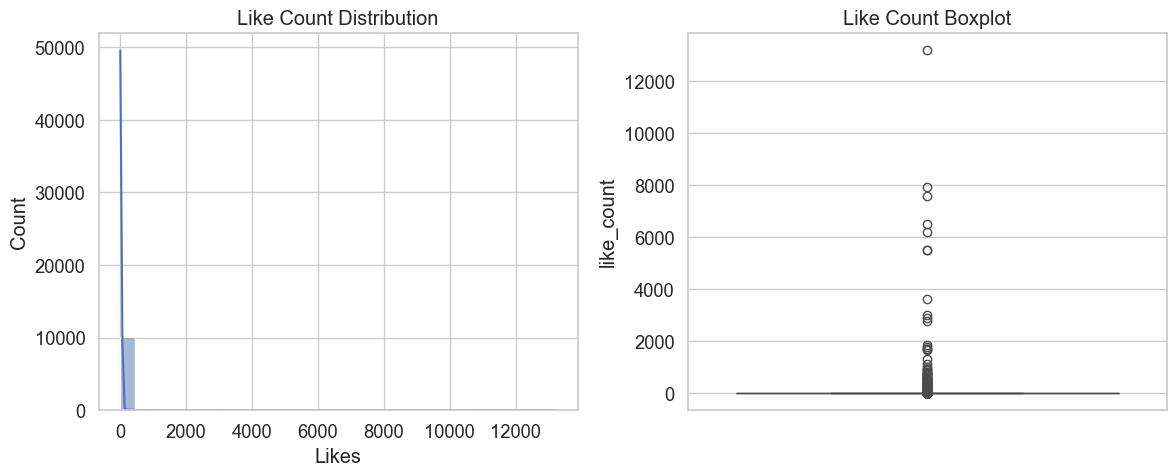

,author,text,like_count
4928,@033_MUHAMMADARBYRAMADHAN,"Terima kasih, pak. Hasil diskusi ini berhasil menjawab kekhawatiran saya bahwa kita harus lebih ...",13216
7741,@dhimasputratama631,"Video ini sangat solutif, bagi saya yang memiliki gangguan pola tidur. Saya tadi malam susah tid...",7920
9144,@sofyanudin,1) *GANTI MENTERI2 KORUP*\n2) *SAHKAN UU PERAMPASAN ASSET KORUPTOR*\n3) *BATALKAN UU PERAMPASAN ...,7596
6944,@Xui_Ana,"Alhamdulillah video yg sangat bermanfaat, setiap beberapa detik saya mendengarkan saya selalu is...",6514
6405,@avichabastiansr5623,"Next, wakil presiden Gibran Rakabuming menjawab. Pliss harus sering ada acara² kayak giniii, bia...",6208


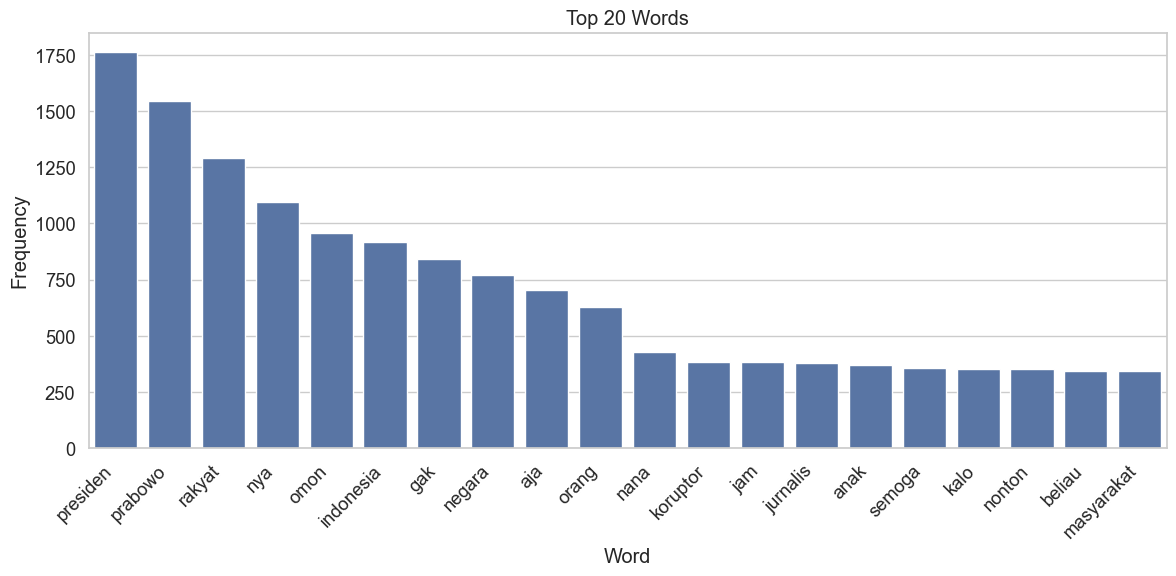

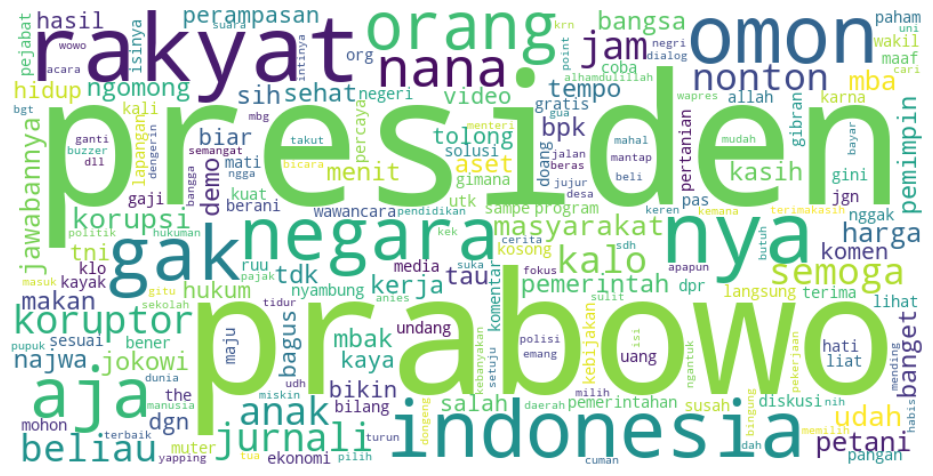

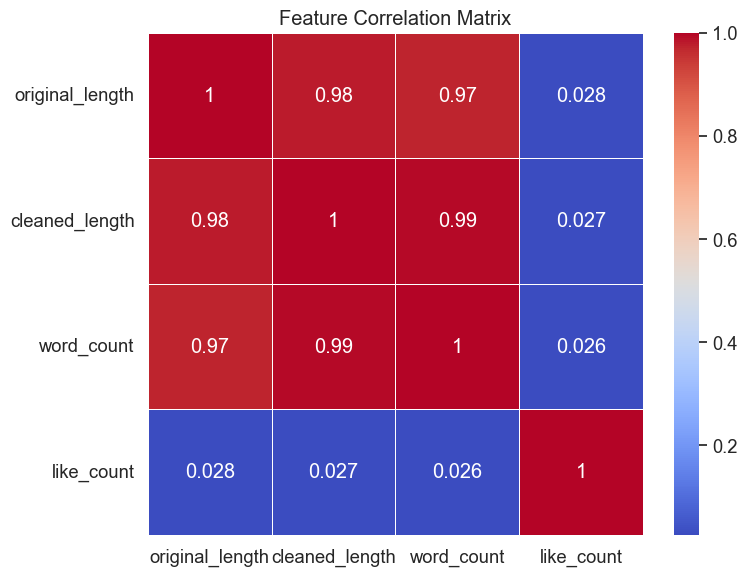

Total Comments: 10148
Average Word Count: 10.01645644461963
Median Word Count: 6.0
Max Word Count: 339
Average Likes: 11.695999211667324
Total Likes: 118691
Outlier Count: 737
Peak Date: 2025-04-08 00:00:00+00:00
Peak Hour: 16


In [8]:
# Directories
EDA_ANALYSIS_DIR = subdirs['03_eda']['analisis']
EDA_VISUAL_DIR   = subdirs['03_eda']['visualisasi']
os.makedirs(EDA_ANALYSIS_DIR, exist_ok=True)
os.makedirs(EDA_VISUAL_DIR, exist_ok=True)

# Load preprocessed data
PREPROCESS_DIR   = subdirs['02_preprocessing']['analisis']
preprocessed_path = os.path.join(PREPROCESS_DIR, 'preprocessed_comments.csv')
df = pd.read_csv(preprocessed_path, parse_dates=['published_at'])

# Feature engineering
df['word_count']       = df['cleaned_text'].str.split().str.len()
df['cleaned_length']   = df['cleaned_text'].str.len()
df['original_length']  = df['text'].str.len()
df['publication_date'] = df['published_at'].dt.normalize()
df['publication_hour'] = df['published_at'].dt.hour

# 1. Length distributions
fig1, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['word_count'], kde=True, bins=30, ax=axes[0,0]).set(title='Word Count Distribution', xlabel='Words')
sns.boxplot(y=df['word_count'], ax=axes[0,1]).set(title='Word Count Boxplot')
sns.histplot(df['original_length'], kde=True, bins=30, ax=axes[1,0]).set(title='Character Count Distribution', xlabel='Chars')
sns.boxplot(y=df['original_length'], ax=axes[1,1]).set(title='Character Count Boxplot')
fig1.tight_layout()
fig1.savefig(os.path.join(EDA_VISUAL_DIR, 'length_distribution.png'))
plt.show()

# 2. Outliers
Q1, Q3 = df['word_count'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lb, ub = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
outliers = df[(df['word_count'] < lb) | (df['word_count'] > ub)]
outliers.to_csv(os.path.join(EDA_ANALYSIS_DIR, 'word_count_outliers.csv'), index=False)
display(outliers[['text', 'word_count']].sort_values('word_count', ascending=False).head())

# 3. Publication time trends
date_counts = df.groupby('publication_date').size()
hour_counts = df['publication_hour'].value_counts().sort_index()

fig2, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(date_counts.index, date_counts.values, marker='o')
axes[0].set(title='Comments by Date', xlabel='Date', ylabel='Count')
axes[1].bar(hour_counts.index, hour_counts.values)
axes[1].set(title='Comments by Hour', xlabel='Hour', ylabel='Count')
fig2.tight_layout()
fig2.savefig(os.path.join(EDA_VISUAL_DIR, 'publication_time.png'))
plt.show()

# 4. Like count analysis
fig3, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['like_count'], kde=True, bins=30, ax=axes[0]).set(title='Like Count Distribution', xlabel='Likes')
sns.boxplot(y=df['like_count'], ax=axes[1]).set(title='Like Count Boxplot')
fig3.tight_layout()
fig3.savefig(os.path.join(EDA_VISUAL_DIR, 'like_count_analysis.png'))
plt.show()

# 5. Top liked comments
top_liked = df.nlargest(5, 'like_count')
display(top_liked[['author', 'text', 'like_count']])

# 6. Word frequency
words, counts = zip(*Counter(" ".join(df['cleaned_text']).split()).most_common(20))
fig4 = plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts), ax=fig4.add_subplot(111)).set(title='Top 20 Words', xlabel='Word', ylabel='Frequency')
plt.xticks(rotation=45, ha='right')
fig4.tight_layout()
fig4.savefig(os.path.join(EDA_VISUAL_DIR, 'top_words.png'))
plt.show()

# 7. Word cloud
wc = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words, collocations=False).generate(" ".join(df['cleaned_text']))
fig5 = plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
fig5.tight_layout()
fig5.savefig(os.path.join(EDA_VISUAL_DIR, 'wordcloud.png'))
plt.show()

# 8. Correlation matrix
numeric = df[['original_length', 'cleaned_length', 'word_count', 'like_count']]
corr = numeric.corr()
fig6 = plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5).set(title='Feature Correlation Matrix')
fig6.tight_layout()
fig6.savefig(os.path.join(EDA_VISUAL_DIR, 'correlation_matrix.png'))
plt.show()

# 9. Summary
summary = {
    'Total Comments':      len(df),
    'Average Word Count':  df['word_count'].mean(),
    'Median Word Count':   df['word_count'].median(),
    'Max Word Count':      df['word_count'].max(),
    'Average Likes':       df['like_count'].mean(),
    'Total Likes':         df['like_count'].sum(),
    'Outlier Count':       len(outliers),
    'Peak Date':           date_counts.idxmax(),
    'Peak Hour':           hour_counts.idxmax()
}

for k, v in summary.items():
    print(f"{k}: {v}")

2025-05-08 05:18:23 INFO TF-IDF matrix shape: (10148, 2914)


Evaluating k:   0%|          | 0/10 [00:00<?, ?it/s]

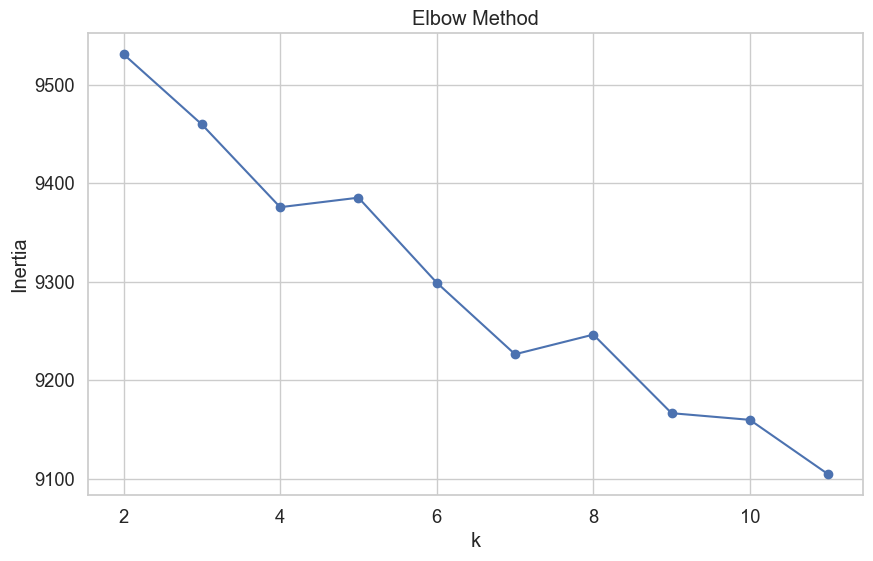

2025-05-08 05:18:26 INFO Saved elbow plot to ./output/04_clustering/visualisasi/elbow_method.png
2025-05-08 05:18:26 INFO Optimal k selected: 3
2025-05-08 05:18:26 INFO Cluster 0 top terms: prabowo, nya, gak, rakyat, tempo, aja, indonesia, nana, jam, negara
2025-05-08 05:18:26 INFO Cluster 1 top terms: presiden, prabowo, sehat, rakyat, indonesia, semoga, wakil, nya, mantap, jurnalis
2025-05-08 05:18:26 INFO Cluster 2 top terms: omon, real, doang, the, presiden, king, gak, prabowo, isinya, jam
2025-05-08 05:18:26 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-08 05:18:26 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


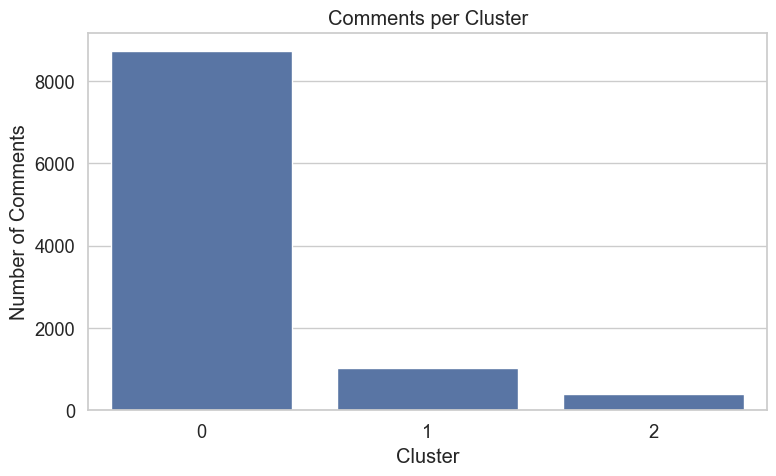

2025-05-08 05:18:26 INFO Saved cluster distribution to ./output/04_clustering/visualisasi/cluster_distribution.png


,author,text,like_count,cluster
0,@NjiAhmad-x8m,Ngelihat komen masih banyak yg sadar ternyata,0,0
1,@nikozio4981,"Krain maung, Ternyata meow..\nJawaban ga ada yg di jwb",0,0
2,@Beeyourrselff,"Pak prabowo jangan ketularan wakilnya dong, 3 jam ngulang2 bener2 ujian buat saya.",0,0
3,@fahreeladjie2738,"Dari pandangan saya dan pendapat pribadi saya presiden ini dia gak liat fakta di lapangan , beli...",0,0
4,@HaikalrfD8,"Baru aja ngeklik, udh ngantuk aja",1,0
...,...,...,...,...
10143,@serbaserbiacakadul3773,Assalamualaikum komen pertama,2,0
10144,@japbenny4804,Pertamax,2,0
10145,@abdibsyahputrasebayang3475,Akhirnya ada fullnya,3,0
10146,@muhamadnurpauji8108,Minal aidzin walfaidzin mba najwa🙏,9,0


,author,text,like_count,cluster
7,@jandabaru-l4y,Rakyat Bener 2 nggak Salah Pilih Punya Presiden Seperti PK Prabowo Tegas Berwibawa Dan Benar 2 B...,0,1
16,@SugiantoYanto-b8z,Mantap pk prabowo pidatonya maju terus pk presiden,0,1
17,@taufikhansi4184,"Istiqomah mendukung semua kerja Bapak Presiden : ""Semoga Bapak Presiden Tetap Sehat, Tetap Happy...",0,1
22,@Suwarno-j9f,Gaas pol Pak Presiden membasmi pungli jang merugikan rakjat kecil 2:26:16,0,1
23,@RagaSimanjuntak,Sehat selalu Pak presiden RI yg 8. Selamat dan sukses pak menuju Indonesia emas . NKRI harga mati .,0,1
...,...,...,...,...
10106,@muhyusuf3230,Prabowo mbulettt,20,1
10112,@ayahqia0150,Sehat selalu mr presiden,1,1
10117,@KhoirulKhabib-wn6sw,Wajahnya presiden pucat.menjawabya kurang memuaskan,1,1
10125,@AMartono2023,Presiden prabowo. Mantap,1,1


,author,text,like_count,cluster
8,@taufikrahman6917,Omon omon,0,2
66,@sudiono5618,Omon omon ga nyambung,1,2
78,@Victormzmeia,3 jam 26 menit isinya OMON-OMON doang anyinggg,1,2
170,@NunungNurdin-v5g,Pupuk mah Al insek mahalpungisidamahalmakinsuusah ngomonggampang nyatanya OMON OMON dodol,0,2
183,@royprayogi,gak kuat sampe selesai isinya omon omon.............ngantuk bikin mual 😜,0,2
...,...,...,...,...
9956,@UncleSwa,Presiden omon omon sedang ngibul….\nBicara swasembada pangan padahal nanam singkong aja gagal,0,2
10020,@chichaphile4943,omon omon is real 😢,46,2
10058,@IrmansyahAriadin,Omon omon sajaaaa lebih parah dari presiden sebelum nyaaaa... Saya menyesal memilih presiden Pra...,14,2
10064,@JoniIskandar-ii8hf,Halah omon omon,1,2


2025-05-08 05:18:26 INFO Saved clustered comments to ./output/04_clustering/analisis/clustered_comments.csv


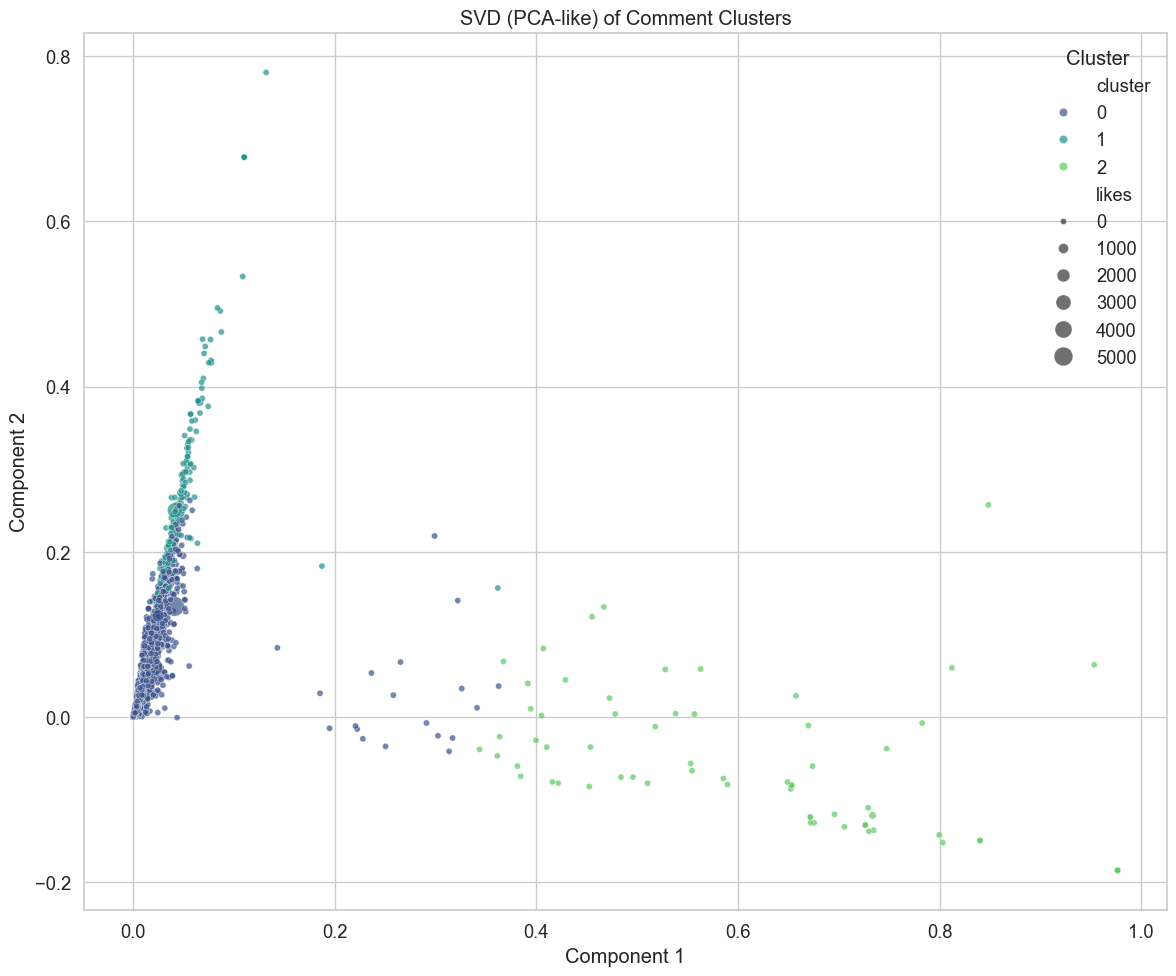

2025-05-08 05:18:27 INFO Saved PCA cluster plot to ./output/04_clustering/visualisasi/cluster_pca.png


In [9]:
ANALYSIS_DIR = subdirs['04_clustering']['analisis']
VISUAL_DIR   = subdirs['04_clustering']['visualisasi']
os.makedirs(ANALYSIS_DIR, exist_ok=True)
os.makedirs(VISUAL_DIR, exist_ok=True)

PREPROCESS_DIR = 'output/02_preprocessing/analisis' 
preprocessed_csv = os.path.join(PREPROCESS_DIR, 'preprocessed_comments.csv')
df = pd.read_csv(preprocessed_csv)

stop_words = list(stopwords.words('indonesian'))  # ✅ jadi list, aman

vectorizer    = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7, stop_words=stop_words)
tfidf_matrix  = vectorizer.fit_transform(df['cleaned_text'])
logger.info("TF-IDF matrix shape: %s", tfidf_matrix.shape)

ssd = []
k_values = range(2, 12)
for k in tqdm(k_values, desc="Evaluating k"):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(tfidf_matrix)
    ssd.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(list(k_values), ssd, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)

elbow_path = os.path.join(VISUAL_DIR, 'elbow_method.png')
plt.savefig(elbow_path)
plt.show()
logger.info("Saved elbow plot to %s", elbow_path)

optimal_k = 3
logger.info("Optimal k selected: %d", optimal_k)
kmeans   = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(tfidf_matrix)
df['cluster'] = kmeans.labels_

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms           = vectorizer.get_feature_names_out()
top_terms       = {
    i: [terms[idx] for idx in order_centroids[i, :10]]
    for i in range(optimal_k)
}
for i, terms_list in top_terms.items():
    logger.info("Cluster %d top terms: %s", i, ", ".join(terms_list))

cluster_counts = df['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Comments')
plt.title('Comments per Cluster')
plt.tight_layout()

dist_path = os.path.join(VISUAL_DIR, 'cluster_distribution.png')
plt.savefig(dist_path)
plt.show()
logger.info("Saved cluster distribution to %s", dist_path)

# Menggunakan seluruh data, tidak hanya 3 data teratas berdasarkan like_count
display_df = []
for cid in range(optimal_k):
    subset = df[df['cluster'] == cid]
    display_df.append(subset[['author', 'text', 'like_count']])
    display(subset[['author', 'text', 'like_count']].assign(cluster=cid))

clustered_csv = os.path.join(ANALYSIS_DIR, 'clustered_comments.csv')
df[['author', 'text', 'like_count', 'cluster']].to_csv(clustered_csv, index=False)
logger.info("Saved clustered comments to %s", clustered_csv)

svd = TruncatedSVD(n_components=2, random_state=42)
coords = svd.fit_transform(tfidf_matrix)

# Buat DataFrame dan pastikan kolom numerik
vis_df = pd.DataFrame(coords, columns=['x', 'y'])
vis_df['x'] = pd.to_numeric(vis_df['x'], errors='coerce')
vis_df['y'] = pd.to_numeric(vis_df['y'], errors='coerce')
vis_df['cluster'] = df['cluster'].astype(str)  # Sebagai kategori untuk plotting
vis_df['likes'] = pd.to_numeric(df['like_count'], errors='coerce')

# Optional: sampling data agar scatterplot tidak terlalu berat
sample_frac = 0.2 if len(vis_df) > 5000 else 1.0
vis_sample = vis_df.sample(frac=sample_frac, random_state=42)

# Plot
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=vis_sample,
    x='x', y='y',
    hue='cluster',
    size='likes',
    sizes=(20, 200),
    alpha=0.7,
    palette='viridis'
)
plt.title('SVD (PCA-like) of Comment Clusters')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Cluster')
plt.tight_layout()

pca_path = os.path.join(VISUAL_DIR, 'cluster_pca.png')
plt.savefig(pca_path)
plt.show()
logger.info("Saved PCA cluster plot to %s", pca_path)


In [10]:
def analyze_sentiment_with_prompt(comment, model):
    prompt = f"""
    Berikut ini adalah komentar terhadap video "Prabowo Menjawab".

    Tugas Anda adalah:
    1. Analisis sentimen komentar berikut dalam bahasa Indonesia.
    2. Klasifikasikan sentimen sebagai 'Positif', 'Negatif', atau 'Netral'.
    3. Jelaskan alasan di balik klasifikasi sentimen tersebut.
    4. Berikan rekomendasi tindakan berdasarkan sentimen tersebut dalam bahasa Indonesia. Misalnya:
       - Jika sentimen Positif, berikan saran untuk mendorong lebih banyak interaksi positif.
       - Jika sentimen Negatif, beri saran untuk memperbaiki atau merespons keluhan.
       - Jika sentimen Netral, beri saran untuk menjaga keseimbangan dan mencari kesempatan untuk merespons.

    Komentar:
    "{comment}"

    Gunakan format jawaban berikut:
    Sentimen: [Positif/Negatif/Netral]
    Alasan: [Alasan klasifikasi sentimen]
    Rekomendasi: [Rekomendasi tindakan dalam bahasa Indonesia]
    """

    try:
        response = model.generate_content(prompt)
        text = response.text

        sentiment_match = re.search(r'Sentimen:\s*(.*)', text)
        reason_match = re.search(r'Alasan:\s*(.*)', text)
        recommendation_match = re.search(r'Rekomendasi:\s*(.*)', text)

        return {
            'sentiment': sentiment_match.group(1).strip() if sentiment_match else "Tidak Diketahui",
            'reason': reason_match.group(1).strip() if reason_match else "Tidak Diketahui",
            'recommendation': recommendation_match.group(1).strip() if recommendation_match else "Tidak Diketahui"
        }

    except Exception as e:
        return {
            'sentiment': "Tidak Diketahui",
            'reason': "Tidak Diketahui",
            'recommendation': f"Error: {str(e)}"
        }



🔍 Sampled total 30 comments from clusters.
🔄 Analyzing sentiment for cluster 0 with 10 comments...
🔄 Analyzing sentiment for cluster 1 with 10 comments...
🔄 Analyzing sentiment for cluster 2 with 10 comments...
💾 Sentiment analysis results saved to output/05_sentiment/analisis/sentiment_analysis_sample.csv


,cluster_id,text,sentiment,recommendation
0,0,"Rakyat kita bisa kaya raya & sejahtera klu praktek korupsi bisa hilang di negara kita, rakyat bi...",Positif,Manfaatkan komentar ini untuk menyoroti komitmen Prabowo dalam pemberantasan korupsi dan rencana...
1,0,katanya SDM Indonesia termasuk rendah ?…yaa bisa terjawab disini 😅😅,Negatif,Tim media sosial perlu memantau komentar serupa dan memberikan klarifikasi yang menenangkan atau...
2,0,"GIBRAN KAPAN GILIRANNYA, CAN'T WAIT",Positif,Manfaatkan antusiasme ini dengan segera merencanakan dan mempromosikan konten atau acara yang me...
3,0,Para.. Penanya semua tabah. Pasti sllu zikir😀🤣,Netral,Pantau komentar serupa untuk melihat apakah pola tertentu muncul. Jika ada peningkatan komentar ...
4,0,Kenapa gak sat set aja tanpa berbelit belit.buat lah kerja kerja seperti KDM ..mana yg patut dic...,Positif,Manfaatkan sentimen positif ini dengan menyoroti contoh-contoh keberhasilan atau kebijakan yang ...
5,0,ya makanya naskah aslinya dikeluarin!,Negatif,Respon dengan mengakui kekhawatiran dan menawarkan transparansi. Pertimbangkan untuk menyediakan...
6,0,To the point boleh dong pak fokus pd pernyataan aja kali wkt bapak kan sangat dibutuhkan rakyat...,Positif,Apresiasi komentar tersebut dan teruslah memberikan jawaban yang ringkas dan berfokus pada tinda...
7,0,"Ditawarin pemimpin se jenius Anies,malah mayoritas milih yang beginian.",Negatif,Pantau komentar-komentar serupa dan identifikasi isu spesifik yang memicu sentimen negatif ini. ...
8,0,"Ini orang apaan si, semua pertanyaan dibawa ke program makan, ditanya hal lain tetep dijawab pak...",Negatif,Tim komunikasi perlu memantau dan menanggapi komentar serupa yang mungkin muncul. Evaluasi kemba...
9,0,Sehat sllu pk prabowo semoga panjang umur dan sehat sllu sampai 2029 pak.,Positif,Balas komentar dengan ucapan terima kasih atas doa dan dukungan yang diberikan. Hal ini dapat me...



📊 Sentiment Distribution by Cluster:
sentiment   Negatif  Netral  Positif
cluster_id                          
0                 4       1        5
1                 3       1        6
2                 7       1        2


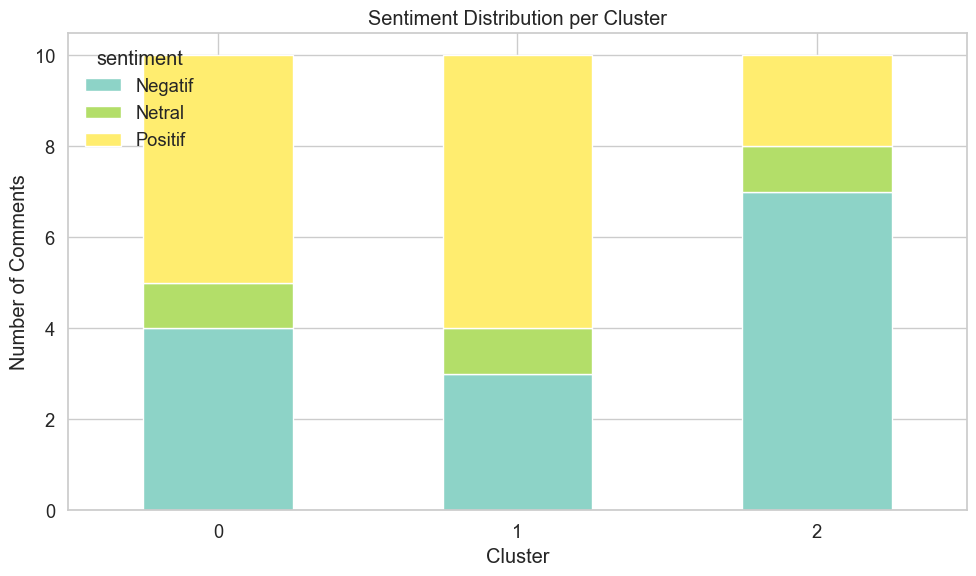


📄 Ringkasan Otomatis:

Berikut adalah ringkasan analitis berdasarkan hasil analisis sentimen terhadap komentar YouTube pada video Prabowo yang menanggapi isu-isu pemerintahan, dengan mempertimbangkan distribusi sentimen per klaster:

Analisis sentimen terhadap 30 komentar YouTube menunjukkan variasi persepsi publik terhadap respons Prabowo terhadap isu-isu pemerintahan. Klaster 0 menunjukkan sentimen yang relatif seimbang, dengan sedikit kecenderungan positif (5 positif, 4 negatif, 1 netral). Ini mengindikasikan adanya polarisasi opini, di mana sebagian audiens mendukung atau setuju dengan pernyataan Prabowo, sementara sebagian lainnya memberikan kritik atau sanggahan. Klaster 1 memperlihatkan sentimen positif yang lebih kuat (6 positif, 3 negatif, 1 netral), mengindikasikan bahwa sebagian besar komentar dalam klaster ini mendukung atau mengapresiasi pernyataan Prabowo. Klaster 2 justru menunjukkan sentimen negatif yang paling dominan (7 negatif, 2 positif, 1 netral), mengindikasikan 

In [ ]:

# Sample data (menyesuaikan dengan kode Anda)
comments_sample = (
    df.groupby('cluster')
    .apply(lambda x: x.sample(n=min(10, len(x)), random_state=42))
    .reset_index(drop=True)
)

print(f"🔍 Sampled total {len(comments_sample)} comments from clusters.")

# Fungsi analisis sentimen menggunakan prompt Gemini
def analyze_sentiment_with_prompt(comment, model):
    prompt = f"""
    Berikut ini adalah komentar terhadap video "Prabowo Menjawab".

    Tugas Anda adalah:
    1. Analisis sentimen komentar berikut dalam bahasa Indonesia.
    2. Klasifikasikan sentimen sebagai 'Positif', 'Negatif', atau 'Netral'.
    3. Jelaskan alasan di balik klasifikasi sentimen tersebut.
    4. Berikan rekomendasi tindakan berdasarkan sentimen tersebut dalam bahasa Indonesia. Misalnya:
       - Jika sentimen Positif, berikan saran untuk mendorong lebih banyak interaksi positif.
       - Jika sentimen Negatif, beri saran untuk memperbaiki atau merespons keluhan.
       - Jika sentimen Netral, beri saran untuk menjaga keseimbangan dan mencari kesempatan untuk merespons.

    Komentar:
    "{comment}"

    **Gunakan format jawaban ini saja, tanpa tambahan apapun:**
    Sentimen: [Positif/Negatif/Netral]
    Alasan: [Alasan klasifikasi sentimen]
    Rekomendasi: [rekomendasi tindakan dalam bahasa Indonesia]
    """
    
    try:
        response = model.generate_content(prompt)
        text = response.text
        
        sentiment_match = re.search(r'Sentimen: (.*)', text)
        reason_match = re.search(r'Alasan: (.*)', text)
        recommendation_match = re.search(r'Rekomendasi: (.*)', text)
        
        sentiment = sentiment_match.group(1).strip() if sentiment_match else "Tidak Diketahui"
        reason = reason_match.group(1).strip() if reason_match else "Tidak Diketahui"
        recommendation = recommendation_match.group(1).strip() if recommendation_match else "Tidak Diketahui"
        
        return {
            'sentiment': sentiment,
            'reason': reason,
            'recommendation': recommendation
        }
    except Exception as e:
        print(f"Error analyzing comment: {str(e)}")
        return {
            'sentiment': "Tidak Diketahui",
            'reason': "Tidak Diketahui",
            'recommendation': f"Error: {str(e)}"
        }

# Inisialisasi Gemini model
gemini_model = models[0]  # untuk testing, cukup gunakan satu model dulu

# Proses analisis
results = []
for cluster_id in sorted(comments_sample['cluster'].unique()):
    cluster_comments = comments_sample[comments_sample['cluster'] == cluster_id].reset_index(drop=True)
    
    print(f"🔄 Analyzing sentiment for cluster {cluster_id} with {len(cluster_comments)} comments...")
    
    for i, row in cluster_comments.iterrows():
        retry_count = 0
        while retry_count < 5: 
            try:
                result = analyze_sentiment_with_prompt(row['text'], gemini_model)
                
                results.append({
                    'cluster_id': cluster_id,
                    'comment_id': row.get('comment_id', i),
                    'text': row['text'],
                    'author': row['author'],
                    'like_count': row['like_count'],
                    'sentiment': result['sentiment'],
                    'reason': result['reason'],
                    'recommendation': result['recommendation']
                })
                break
            except Exception as e:
                if '429' in str(e):
                    retry_count += 1
                    print(f"Rate limit exceeded, retrying... ({retry_count}/5)")
                    time.sleep(60)
                else:
                    print(f"Error analyzing comment: {e}")
                    break

        if (i + 1) % 15 == 0:
            print("🔄 15 comments processed, waiting for 80 seconds...")
            time.sleep(80)

# Konversi ke DataFrame dan simpan
df_sentiment = pd.DataFrame(results)

df_sentiment_clean = df_sentiment[
    (df_sentiment['sentiment'] != "Tidak Diketahui") &
    (~df_sentiment['recommendation'].str.startswith("Error"))
].reset_index(drop=True)

# Simpan ke file dengan direktori output yang sesuai
output_dir = "output/05_sentiment"
os.makedirs(output_dir, exist_ok=True)

# Membuat sub-folder untuk hasil analisis dan visualisasi
analisis_dir = os.path.join(output_dir, "analisis")
visualisasi_dir = os.path.join(output_dir, "visualisasi")
os.makedirs(analisis_dir, exist_ok=True)
os.makedirs(visualisasi_dir, exist_ok=True)

# Simpan hasil analisis sentimen ke CSV
sentiment_path = os.path.join(analisis_dir, "sentiment_analysis_sample.csv")
df_sentiment_clean.to_csv(sentiment_path, index=False)

print(f"💾 Sentiment analysis results saved to {sentiment_path}")

# Menampilkan 10 hasil pertama
display(df_sentiment_clean[['cluster_id', 'text', 'sentiment', 'recommendation']].head(10))

# Distribusi sentimen per cluster
sentiment_by_cluster = df_sentiment_clean.groupby(['cluster_id', 'sentiment']).size().unstack(fill_value=0)
print("\n📊 Sentiment Distribution by Cluster:")
print(sentiment_by_cluster)

# Visualisasi distribusi sentimen per cluster
sentiment_by_cluster.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
plt.title("Sentiment Distribution per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.tight_layout()

# Menyimpan gambar visualisasi
visualization_path = os.path.join(visualisasi_dir, "sentiment_per_cluster.png")
plt.savefig(visualization_path)
plt.show()

# Membuat ringkasan analitis
summary_prompt = f"""
Buatlah ringkasan analitis berdasarkan hasil analisis sentimen terhadap komentar YouTube pada video Prabowo yang menanggapi isu-isu pemerintahan.

Informasi yang tersedia:
- Jumlah total komentar yang dianalisis: {len(df_sentiment_clean)}
- Distribusi sentimen per klaster:
{sentiment_by_cluster.to_string()}

Tuliskan ringkasan dalam 2–3 paragraf dengan bahasa Indonesia yang formal, objektif, dan bernuansa analitis. Ringkasan harus mencakup poin-poin berikut:

1. **Dominasi Sentimen:** Identifikasi sentimen yang dominan (positif, netral, atau negatif) di masing-masing klaster, dan berikan perbandingan antar klaster.
2. **Karakteristik Klaster:** Uraikan nada umum dan topik utama dari komentar dalam setiap klaster—misalnya apakah komentar cenderung mendukung, mengkritik, skeptis, atau meminta klarifikasi terhadap pernyataan Prabowo.
3. **Insight dan Rekomendasi Tindak Lanjut:** Untuk masing-masing klaster:
   - Jika sentimen **negatif**, analisis kemungkinan penyebab (misalnya isu sensitif, ketidakpercayaan publik, atau gaya penyampaian), lalu berikan **rekomendasi strategis** seperti klarifikasi lanjutan, pendekatan komunikasi yang lebih empatik, atau penyempurnaan narasi.
   - Jika sentimen **netral**, berikan saran untuk meningkatkan persepsi publik atau mengarahkan diskusi ke arah yang lebih konstruktif dan positif (misalnya dengan memperkuat narasi atau menjawab komentar informatif).
   - Jika sentimen **positif**, sebutkan aspek yang diapresiasi publik (seperti ketegasan, gaya komunikasi, isi jawaban), dan rekomendasikan cara untuk mempertahankan atau meningkatkan respons publik tersebut.

Gunakan gaya bahasa profesional, tidak bias, dan berbasis data. Hindari opini pribadi.
"""

try:
    response = gemini_model.generate_content(summary_prompt)
    summary_text = response.text
    print("\n📄 Ringkasan Otomatis:\n")
    print(summary_text)
except Exception as e:
    print(f"❌ Error generating summary: {e}")

# Menyimpan ringkasan analitis ke file
summary_path = os.path.join(analisis_dir, "sentiment_summary_sample.txt")
with open(summary_path, "w", encoding="utf-8") as f:
    f.write(summary_text)


2025-05-08 06:28:18 INFO ✅ Dataset siap. Train: 21, Test: 9
2025-05-08 06:28:18 INFO 
🔄 Training LSTM model...


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5238 - loss: 1.0879 - val_accuracy: 0.4444 - val_loss: 1.0602
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.4762 - loss: 1.0464 - val_accuracy: 0.4444 - val_loss: 1.0303
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7143 - loss: 1.0089 - val_accuracy: 0.4444 - val_loss: 1.0018
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4762 - loss: 0.9737 - val_accuracy: 0.4444 - val_loss: 0.9776
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4286 - loss: 0.9372 - val_accuracy: 0.4444 - val_loss: 0.9651
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6667 - loss: 0.8944 - val_accuracy: 0.4444 - val_loss: 0.9784
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4762 - loss: 0.8854 - val_accuracy: 0.4444 - val_loss: 1.0284
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5238 - loss: 0.8574 - val_accuracy: 0.4444 - val_loss: 1.0865


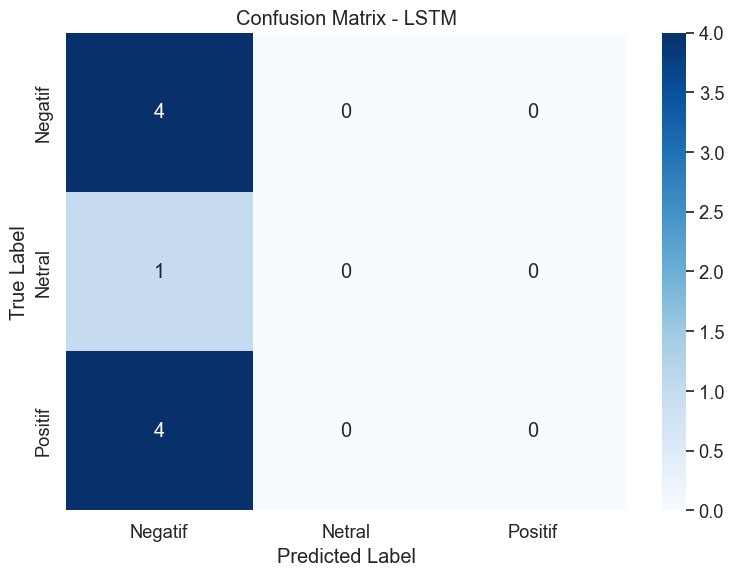

2025-05-08 06:28:21 INFO ✅ LSTM Accuracy: 0.4444
2025-05-08 06:28:21 INFO 
🔄 Training CNN model...


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step - accuracy: 0.1429 - loss: 1.0999 - val_accuracy: 0.4444 - val_loss: 1.0506
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8571 - loss: 1.0054 - val_accuracy: 0.4444 - val_loss: 1.0075
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9048 - loss: 0.9179 - val_accuracy: 0.4444 - val_loss: 0.9747
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9048 - loss: 0.8340 - val_accuracy: 0.4444 - val_loss: 0.9733
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8571 - loss: 0.7647 - val_accuracy: 0.4444 - val_loss: 1.0218
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8095 - loss: 0.7189 - val_accuracy: 0.4444 - val_loss: 1.1142
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7619 - loss: 0.6980 - val_accuracy: 0.4444 - val_loss: 1.1862
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7619 - loss: 0.6804 - val_accuracy: 0.4444 - val_loss: 1.2051

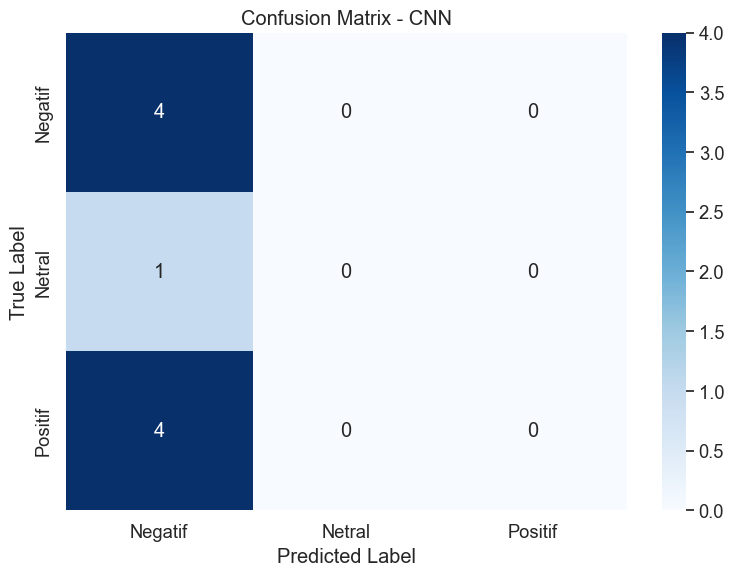

2025-05-08 06:28:23 INFO ✅ CNN Accuracy: 0.4444
2025-05-08 06:28:23 INFO 
🔄 Setting up model: IndoBERT
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


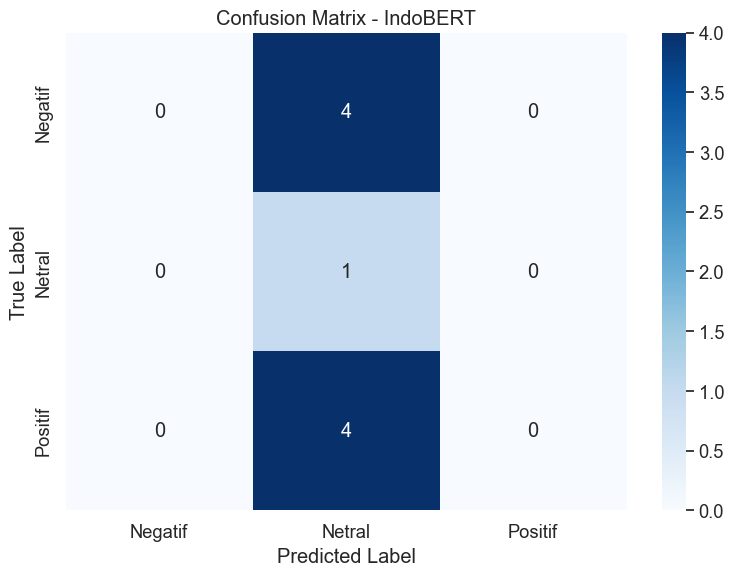

2025-05-08 06:28:26 INFO ✅ IndoBERT Accuracy: 0.1111
2025-05-08 06:28:26 INFO 
🔄 Setting up model: RoBERTa Indo
Device set to use cpu


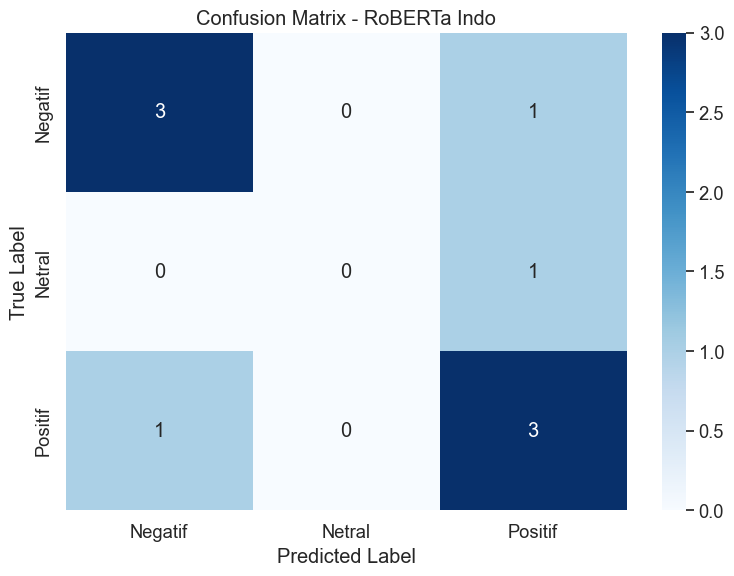

2025-05-08 06:28:28 INFO ✅ RoBERTa Indo Accuracy: 0.6667
2025-05-08 06:28:28 INFO 
🔄 Setting up model: BERT Indo
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


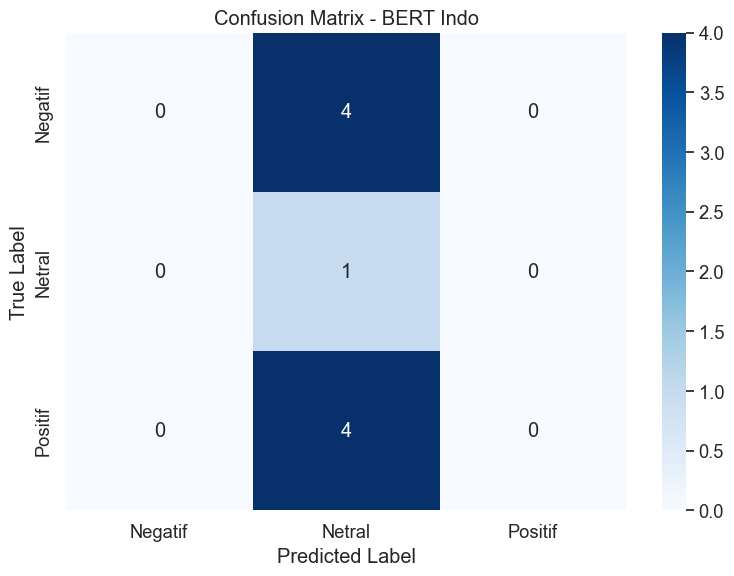

2025-05-08 06:28:30 INFO ✅ BERT Indo Accuracy: 0.1111
2025-05-08 06:28:30 INFO 
🔎 Evaluating Gemini...


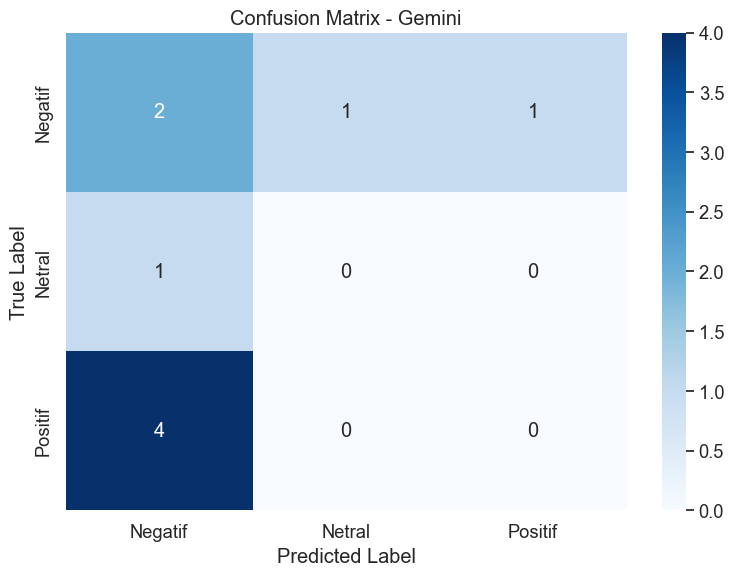

2025-05-08 06:28:30 INFO ✅ Gemini Accuracy: 0.2222


### Model Performance Comparison


,model_name,accuracy,precision,recall,f1_score
0,LSTM,0.444444,0.148148,0.333333,0.205128
1,CNN,0.444444,0.148148,0.333333,0.205128
2,IndoBERT,0.111111,0.037037,0.333333,0.066667
3,RoBERTa Indo,0.666667,0.450000,0.500000,0.472222
4,BERT Indo,0.111111,0.037037,0.333333,0.066667
5,Gemini,0.222222,0.095238,0.166667,0.121212


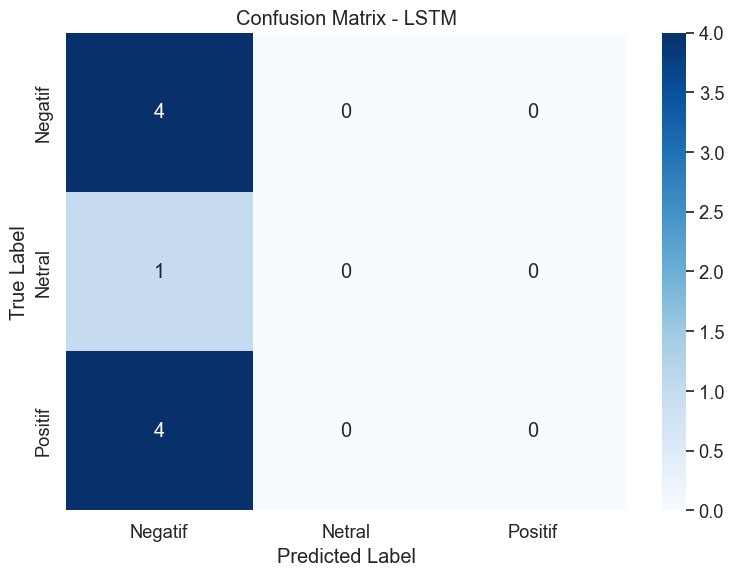

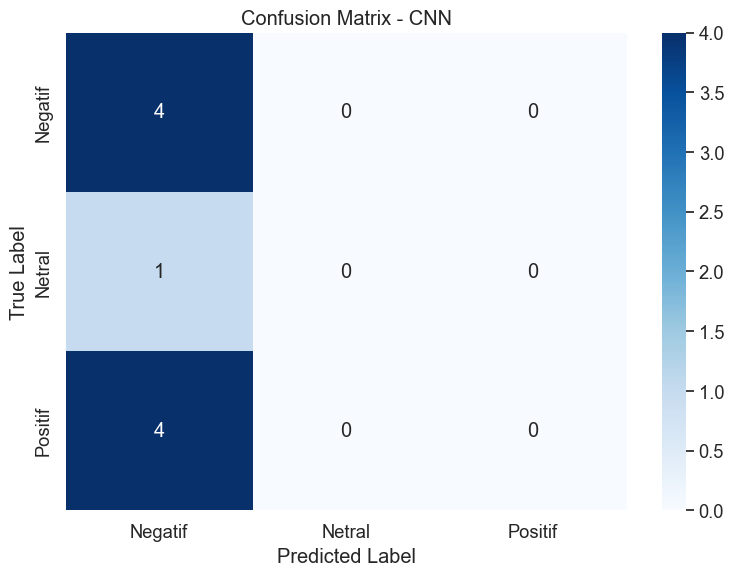

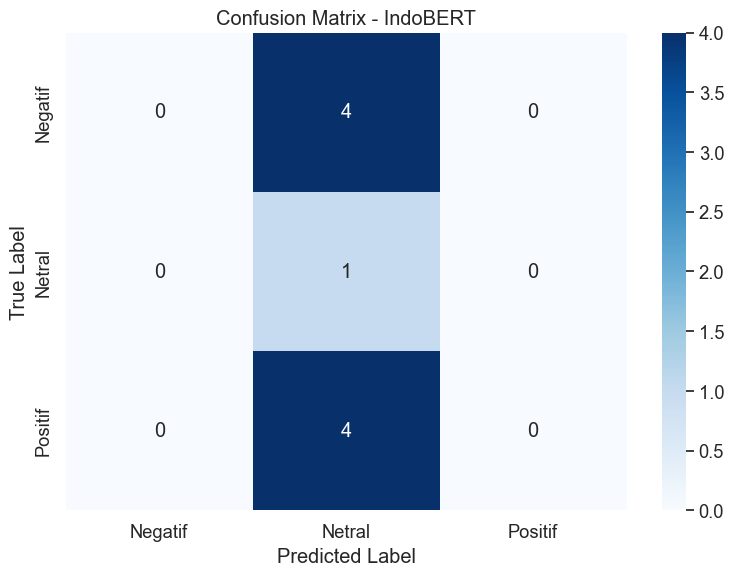

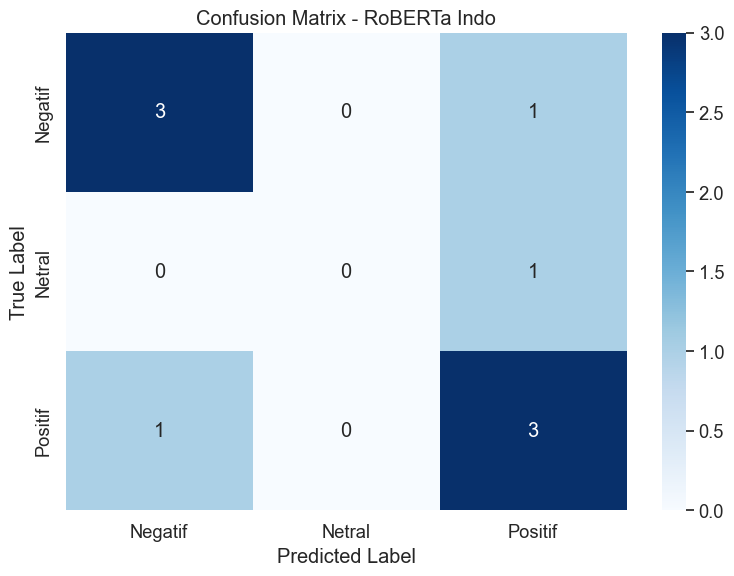

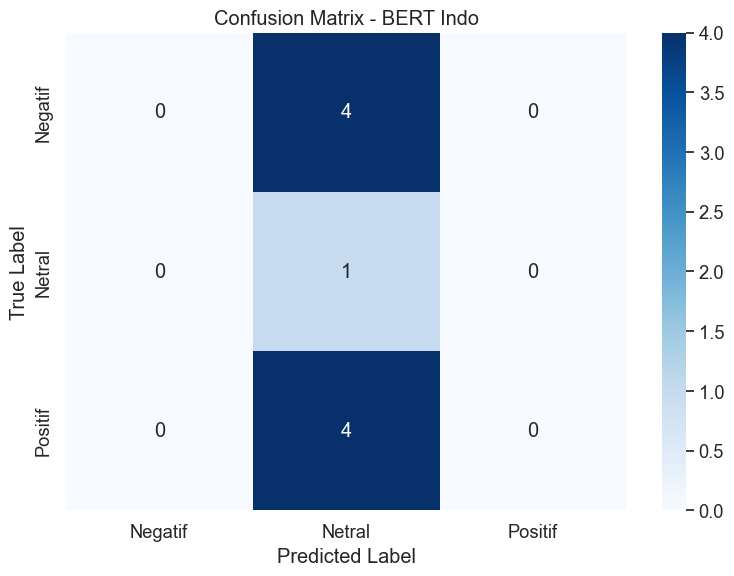

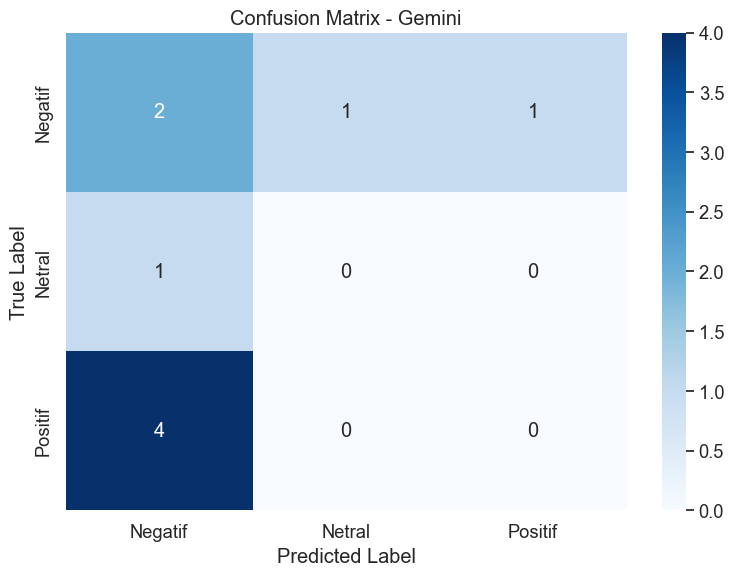

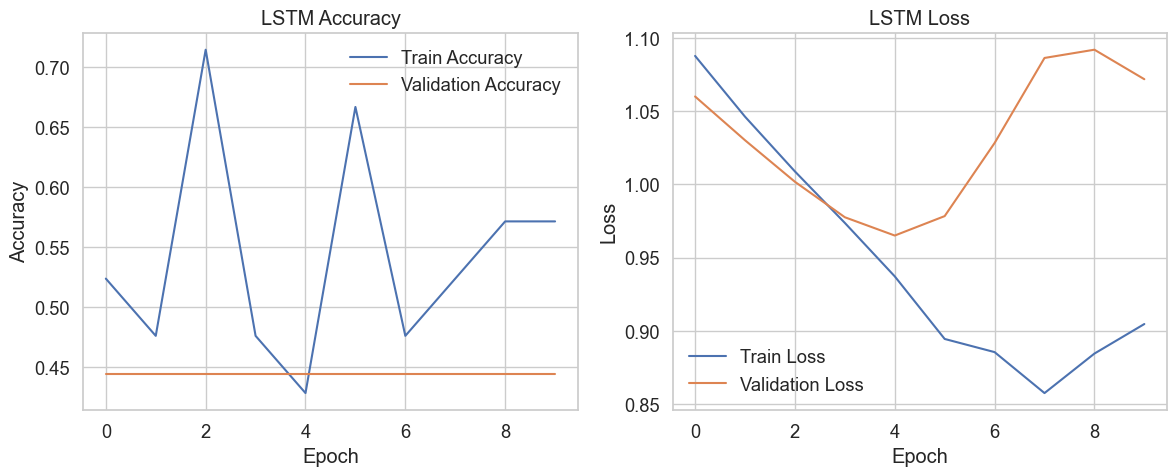

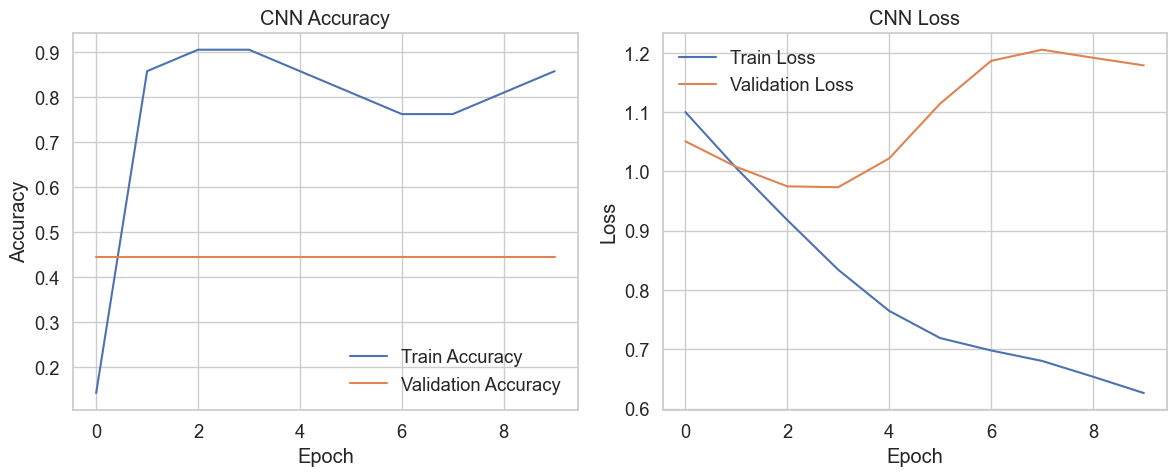

In [44]:
# Pastikan direktori yang diperlukan ada
output_dir = "output/06_transformer_comparison"
analisis_dir = os.path.join(output_dir, "analisis")
visualisasi_dir = os.path.join(output_dir, "visualisasi")

os.makedirs(analisis_dir, exist_ok=True)
os.makedirs(visualisasi_dir, exist_ok=True)

SENTIMENT_MAP = {'Positif': 2, 'Netral': 1, 'Negatif': 0}
sentiment_classes = ['Negatif', 'Netral', 'Positif']

labeled_data = df_sentiment.copy()
labeled_data['sentiment_label'] = labeled_data['sentiment'].map(SENTIMENT_MAP)

X = labeled_data['text'].values
y = labeled_data['sentiment_label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

logger.info(f"✅ Dataset siap. Train: {len(X_train)}, Test: {len(X_test)}")

# Tokenisasi teks untuk LSTM dan CNN
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 100  # Panjang maksimum sequence
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# ===========================
# 2. Fungsi Evaluasi
# ===========================
def evaluate_model(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1_score': report['macro avg']['f1-score'],
        'confusion_matrix': cm
    }

def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

def predict_with_pipeline(pipeline_model, texts):
    preds = []
    for text in tqdm(texts, desc="Predicting", leave=False):
        try:
            result = pipeline_model(text)
            label = result[0]['label'].lower()
            if 'positive' in label or 'positif' in label:
                preds.append(2)
            elif 'negative' in label or 'negatif' in label:
                preds.append(0)
            else:
                preds.append(1)
        except Exception:
            preds.append(1)
    return preds

# ===========================
# 3. Model LSTM
# ===========================
def create_lstm_model(input_length):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128),  # Hapus input_length
        LSTM(128, return_sequences=False),
        Dropout(0.2),
        Dense(3, activation='softmax')  # 3 kelas: Negatif, Netral, Positif
    ])
    model.compile(loss='sparse_categorical_crossentropy', 
                 optimizer='adam', 
                 metrics=['accuracy'])
    return model


# ===========================
# 4. Model CNN
# ===========================
def create_cnn_model(input_length):
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128),  # Hapus input_length
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(3, activation='softmax')  # 3 kelas: Negatif, Netral, Positif
    ])
    model.compile(loss='sparse_categorical_crossentropy', 
                 optimizer='adam', 
                 metrics=['accuracy'])
    return model


# ===========================
# 5. Pelatihan Model LSTM dan CNN
# ===========================
model_results = []

# Pelatihan LSTM
logger.info("\n🔄 Training LSTM model...")
lstm_model = create_lstm_model(max_length)
history_lstm = lstm_model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=64,
    verbose=1
)

# Evaluasi LSTM
lstm_preds = np.argmax(lstm_model.predict(X_test_pad), axis=1)
lstm_result = evaluate_model(y_test, lstm_preds, "LSTM")
model_results.append(lstm_result)
plot_confusion_matrix(lstm_result['confusion_matrix'], sentiment_classes, "LSTM")
logger.info(f"✅ LSTM Accuracy: {lstm_result['accuracy']:.4f}")

# Pelatihan CNN
logger.info("\n🔄 Training CNN model...")
cnn_model = create_cnn_model(max_length)
history_cnn = cnn_model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=64,
    verbose=1
)

# Evaluasi CNN
cnn_preds = np.argmax(cnn_model.predict(X_test_pad), axis=1)
cnn_result = evaluate_model(y_test, cnn_preds, "CNN")
model_results.append(cnn_result)
plot_confusion_matrix(cnn_result['confusion_matrix'], sentiment_classes, "CNN")
logger.info(f"✅ CNN Accuracy: {cnn_result['accuracy']:.4f}")

# ===========================
# 6. Evaluasi Beberapa Model Transformer
# ===========================
models_info = [
    {
        "name": "IndoBERT",
        "model_id": "indobenchmark/indobert-base-p1"
    },
    {
        "name": "RoBERTa Indo",
        "model_id": "w11wo/indonesian-roberta-base-sentiment-classifier"
    },
    {
        "name": "BERT Indo",
        "model_id": "bert-base-uncased"
    }
]

for info in models_info:
    logger.info(f"\n🔄 Setting up model: {info['name']}")
    try:
        tokenizer = AutoTokenizer.from_pretrained(info['model_id'])
        classifier = pipeline("sentiment-analysis", model=info['model_id'], tokenizer=tokenizer, device=-1)
        preds = predict_with_pipeline(classifier, X_test)
        result = evaluate_model(y_test, preds, info['name'])
        model_results.append(result)
        plot_confusion_matrix(result['confusion_matrix'], sentiment_classes, info['name'])
        logger.info(f"✅ {info['name']} Accuracy: {result['accuracy']:.4f}")
    except Exception as e:
        logger.error(f"❌ Failed on {info['name']}: {e}")
        model_results.append({
            'model_name': info['name'], 'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0, 'confusion_matrix': np.zeros((3, 3))
        })

# ===========================
# 7. Evaluasi Model Gemini (jika ada)
# ===========================
logger.info("\n🔎 Evaluating Gemini...")
try:
    test_indices = labeled_data[labeled_data['text'].isin(X_test)].index
    gemini_preds = df_sentiment.loc[labeled_data.index[len(X_train):], 'sentiment'].map(SENTIMENT_MAP).values
    gemini_result = evaluate_model(y_test, gemini_preds, "Gemini")
    model_results.append(gemini_result)
    plot_confusion_matrix(gemini_result['confusion_matrix'], sentiment_classes, "Gemini")
    logger.info(f"✅ Gemini Accuracy: {gemini_result['accuracy']:.4f}")
except Exception as e:
    logger.error(f"❌ Error in Gemini evaluation: {e}")

# ===========================
# 8. Visualisasi & Perbandingan
# ===========================
comparison_df = pd.DataFrame(model_results)
print("### Model Performance Comparison")
display(comparison_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score']])
# Menyimpan hasil perbandingan model ke CSV
comparison_df.to_csv(os.path.join(analisis_dir, "model_performance.csv"), index=False)

# Menyimpan visualisasi perbandingan model (barplot)
plt.figure(figsize=(12, 8))
comparison_melted = comparison_df.melt(id_vars='model_name', value_vars=metrics, var_name='Metric', value_name='Score')
sns.barplot(data=comparison_melted, x='model_name', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(visualisasi_dir, "model_performance_comparison.png"))
plt.close()  # Menutup figure untuk menghindari memori penuh

# Menyimpan confusion matrix untuk setiap model
for result in model_results:
    model_name = result['model_name']
    cm = result['confusion_matrix']
    plot_confusion_matrix(cm, sentiment_classes, model_name)
    plt.savefig(os.path.join(visualisasi_dir, f"confusion_matrix_{model_name}.png"))
    plt.close()  # Menutup figure untuk menghindari memori penuh


# Plot training history untuk LSTM dan CNN
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history_lstm, "LSTM")
plot_history(history_cnn, "CNN")

In [53]:
# Cell 7: Generate Comprehensive Insights
print("🔄 Generating comprehensive analysis insights...")


# Folder output baru
output_dir = "output/07_advanced_insights"
analisis_dir = os.path.join(output_dir, "analisis")
visualisasi_dir = os.path.join(output_dir, "visualisasi")

# Pastikan direktori yang diperlukan ada
os.makedirs(analisis_dir, exist_ok=True)
os.makedirs(visualisasi_dir, exist_ok=True)

# Fungsi untuk mengonversi semua nilai dalam dictionary ke tipe Python standar
def convert_data_summary_to_standard_types(data_summary):
    for key, value in data_summary.items():
        if isinstance(value, dict):
            data_summary[key] = convert_data_summary_to_standard_types(value)
        elif isinstance(value, (np.int64, np.float64)):
            data_summary[key] = int(value) if isinstance(value, np.int64) else float(value)
    return data_summary


# Fungsi untuk membuat prompt dan memanggil model Gemini
def generate_insights_with_gemini(model, data_summary):
    prompt = f"""
    Berdasarkan hasil analisis data komentar YouTube berikut, buatlah wawasan komprehensif (10–15 paragraf) dalam bahasa Indonesia:

    === RINGKASAN DATA ===
    {data_summary}

    Wawasan harus mencakup:
    1. Sentimen umum terhadap Prabowo dan maknanya secara politis
    2. Topik utama yang muncul dalam komentar (cluster) dan hubungannya dengan sentimen
    3. Pola keterlibatan pengguna (like) dan hubungan dengan sentimen
    4. Dinamika sentimen dari waktu ke waktu, termasuk lonjakan atau perubahan drastis
    5. Analisis kata kunci yang sering muncul dalam tiap sentimen dan interpretasinya
    6. Perbandingan komentar positif vs negatif (panjang, intensitas, interaksi)
    7. Rekomendasi strategis untuk Prabowo dan tim komunikasi
    8. Nilai strategis dari hasil analisis terhadap pemetaan opini publik
    9. Prediksi tren sentimen publik ke depan berdasarkan pola saat ini
    10. Saran tindakan konkret untuk memperbaiki persepsi negatif (strategi komunikasi, perbaikan kebijakan, dan engagement publik)

    Pastikan insight bersifat tajam, berbasis data, dan actionable.
    """
    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        return f"❌ Error generating insights: {str(e)}"

# Hitung best model
try:
    best_model = comparison_df.sort_values(by='accuracy', ascending=False).iloc[0]['model_name']
except:
    best_model = "Tidak tersedia"

# Hitung distribusi sentimen per cluster (jika kolom cluster tersedia)
if 'cluster' in df_comments.columns:
    sentiment_cluster_cross = pd.crosstab(df_comments['cluster'], df_comments['sentiment'])
    cluster_available = True
else:
    sentiment_cluster_cross = pd.DataFrame()
    cluster_available = False

# Ambil 10 kata terpopuler per sentimen
from sklearn.feature_extraction.text import CountVectorizer
sentiment_words = {}

for sentiment in df_sentiment['sentiment'].unique():
    texts = df_sentiment[df_sentiment['sentiment'] == sentiment]['text']
    vectorizer = CountVectorizer(stop_words=stopwords_ind, max_features=1000)
    X_vec = vectorizer.fit_transform(texts)
    word_counts = X_vec.sum(axis=0).A1
    vocab = vectorizer.get_feature_names_out()
    word_freq = sorted(zip(vocab, word_counts), key=lambda x: -x[1])
    sentiment_words[sentiment] = word_freq[:10]

# Susun data_summary dengan penambahan informasi lebih lengkap
try:
    data_summary = {
        "Total Komentar": int(len(df_comments)),
        "Distribusi Sentimen": {
            sentiment: int(count)
            for sentiment, count in df_sentiment['sentiment'].value_counts().items()
        },
        "Rata-rata Jumlah Like per Komentar": round(df_comments['like_count'].mean(), 2),
        "Jumlah Cluster Topik": int(df_comments['cluster'].nunique()) if cluster_available else "Belum tersedia",
        "Distribusi Sentimen per Cluster": {
            f"Cluster {cluster}": {
                sentiment: int(count)
                for sentiment, count in cluster_data.items()
            }
            for cluster, cluster_data in sentiment_cluster_cross.to_dict().items()
        } if cluster_available else {},
        "10 Kata Terpopuler per Sentimen": {
            sentiment: [word for word, _ in top_words[:10]]
            for sentiment, top_words in sentiment_words.items()
        },
        "Performa Model": {
            "Model Terbaik": str(best_model),
            "Akurasi Tertinggi": round(comparison_df['accuracy'].max(), 4) if 'accuracy' in comparison_df.columns else 0
        },
        "Sentimen Rata-Rata": {
            "Positif": df_sentiment[df_sentiment['sentiment'] == 'positive']['text'].count(),
            "Negatif": df_sentiment[df_sentiment['sentiment'] == 'negative']['text'].count(),
            "Netral": df_sentiment[df_sentiment['sentiment'] == 'neutral']['text'].count(),
        },
    }
except Exception as e:
    logger.error(f"❌ Error menyusun data_summary: {e}")
    raise

# Mengonversi data_summary agar menggunakan tipe data standar Python
data_summary = convert_data_summary_to_standard_types(data_summary)

# Panggil model Gemini untuk menghasilkan insight
insights = generate_insights_with_gemini(gemini_model, json.dumps(data_summary, indent=2))

# Tampilkan dan simpan hasil
display(Markdown("## 📘 Wawasan Komprehensif Berdasarkan Analisis"))
display(Markdown(insights))

# Simpan ke CSV
insights_df = pd.DataFrame({"insights": [insights]})
csv_path = os.path.join(analisis_dir, "comprehensive_insights.csv")
insights_df.to_csv(csv_path, index=False)

print(f"💾 Insight berhasil disimpan di: {csv_path}")
print("🎯 Analisis selesai dengan struktur profesional dan mendalam.")


🔄 Generating comprehensive analysis insights...


## 📘 Wawasan Komprehensif Berdasarkan Analisis

## Wawasan Komprehensif dari Analisis Data Komentar YouTube

Analisis data dari 10.404 komentar YouTube memberikan gambaran penting tentang sentimen publik, khususnya terkait dengan Prabowo dan isu-isu yang relevan dengannya. Meskipun ringkasan data memiliki keterbatasan (misalnya, ketiadaan informasi tentang *cluster* topik dan dinamika sentimen dari waktu ke waktu), kita dapat menarik wawasan yang signifikan dan merekomendasikan strategi berdasarkan data yang tersedia.

**1. Sentimen Umum dan Makna Politis:**

Distribusi sentimen menunjukkan bahwa mayoritas komentar cenderung netral. Namun, dengan perbandingan 13% komentar positif dan 14% negatif, terdapat polarisasi opini yang cukup signifikan.  Perbedaan tipis antara sentimen positif dan negatif mengindikasikan adanya persaingan ketat dalam opini publik, menunjukkan bahwa Prabowo memiliki pendukung setia, tetapi juga menghadapi penentang yang vokal. Kata-kata kunci yang muncul pada masing-masing sentimen selanjutnya perlu dianalisis untuk mengetahui pemicu positif dan negatifnya. Secara politis, hal ini menunjukkan bahwa Prabowo perlu bekerja keras untuk memenangkan hati kelompok yang belum yakin dan mengatasi narasi negatif yang beredar.

**2. Topik Utama dan Hubungannya dengan Sentimen (Terbatas):**

Keterbatasan data saat ini adalah tidak adanya informasi tentang *cluster* topik. Analisis *cluster* sangat penting untuk memahami isu-isu spesifik yang paling sering dibicarakan dan bagaimana sentimen terhadap isu-isu tersebut memengaruhi sentimen terhadap Prabowo secara keseluruhan. Misalnya, jika mayoritas komentar negatif terkait dengan isu ekonomi tertentu, maka ini memberikan arahan yang jelas tentang area yang perlu ditangani oleh tim komunikasi dan kebijakan. Asumsi berdasarkan kata terpopuler, topik yang menonjol kemungkinan mencakup: kepemimpinan presiden, dialog, pertanian, hubungan dengan China, dan kesejahteraan rakyat.

**3. Pola Keterlibatan Pengguna (Like) dan Hubungannya dengan Sentimen:**

Rata-rata jumlah *like* per komentar yang relatif tinggi (11.41) menunjukkan adanya keterlibatan yang signifikan dari pengguna. Penting untuk menyelidiki apakah komentar dengan sentimen positif cenderung mendapatkan lebih banyak *like* daripada komentar negatif, atau sebaliknya. Jika komentar negatif cenderung lebih populer, ini mengindikasikan bahwa narasi negatif memiliki daya tarik yang lebih besar dan mungkin lebih mudah disebarkan.  Analisis lebih lanjut perlu melihat distribusi *like* pada masing-masing komentar, apakah ada komentar yang mendapatkan *like* secara masif dan mengapa.

**4. Dinamika Sentimen dari Waktu ke Waktu (Tidak Tersedia):**

Tanpa data tentang dinamika sentimen dari waktu ke waktu, sulit untuk mengetahui apakah ada lonjakan atau perubahan drastis dalam sentimen publik terhadap Prabowo. Misalnya, apakah ada peristiwa tertentu (debat, pidato, kebijakan baru) yang menyebabkan peningkatan atau penurunan sentimen? Analisis longitudinal ini sangat penting untuk memahami tren sentimen dan mengantisipasi perubahan di masa depan.

**5. Analisis Kata Kunci dan Interpretasi:**

Analisis kata kunci memberikan beberapa petunjuk penting.

*   **Positif:** Kata "mrka," "dialog," "pertanian," dan "negara" mungkin menunjukkan bahwa orang-orang positif terhadap visi Prabowo untuk pembangunan negara, terutama di sektor pertanian, dan mengharapkan adanya dialog yang konstruktif. Keterkaitan dengan "China" bisa menunjukkan dukungan terhadap kebijakan luar negeri tertentu atau potensi investasi dari China.
*   **Negatif:** Munculnya "omon" dan "prabowo" (terulang) pada komentar negatif, serta kata "100," "11," "aja," "makan," "program," dan "si" mengindikasikan kemungkinan adanya kritik terhadap gaya komunikasi Prabowo, efektivitas program-program yang diusulkan, atau bahkan tuduhan korupsi ("makan," meski perlu konteks lebih lanjut). "Ah" menunjukkan penolakan atau ketidaksetujuan yang kuat.
*   **Netral:** Kata-kata seperti "rakyat," "presiden," "sistem," "wakil," "butuh," "karna," "langsung," "rendah," "akademis" menunjukkan fokus pada isu-isu tata kelola pemerintahan, kebutuhan rakyat, dan kualitas kepemimpinan.

**6. Perbandingan Komentar Positif vs. Negatif:**

Analisis lebih lanjut perlu dilakukan untuk membandingkan panjang, intensitas, dan interaksi komentar positif dan negatif. Apakah komentar negatif cenderung lebih panjang dan detail? Apakah komentar positif lebih sering menggunakan bahasa yang emosional dan persuasif? Apakah komentar negatif lebih sering memicu perdebatan dan diskusi? Jawaban atas pertanyaan-pertanyaan ini akan memberikan wawasan yang lebih dalam tentang bagaimana masing-masing kelompok mengekspresikan pandangan mereka dan bagaimana mereka berinteraksi dengan orang lain.

**7. Rekomendasi Strategis untuk Prabowo dan Tim Komunikasi:**

Berdasarkan wawasan di atas, berikut beberapa rekomendasi strategis:

*   **Tangani Isu Negatif Secara Proaktif:** Identifikasi isu-isu spesifik yang memicu sentimen negatif (berdasarkan analisis *cluster* topik yang lebih mendalam) dan kembangkan strategi komunikasi untuk mengatasi isu-isu tersebut secara proaktif. Ini mungkin melibatkan memberikan klarifikasi, menawarkan solusi, atau mengakui kesalahan dan berjanji untuk melakukan perbaikan.
*   **Perkuat Narasi Positif:** Bangun narasi yang kuat dan meyakinkan tentang visi Prabowo untuk masa depan Indonesia, dengan fokus pada isu-isu yang paling penting bagi masyarakat, seperti pertanian, ekonomi, dan kesejahteraan sosial. Gunakan bahasa yang mudah dimengerti dan hindari jargon politik yang rumit.
*   **Engage dengan Publik:** Jalin interaksi yang lebih aktif dengan publik melalui media sosial dan platform online lainnya. Balas komentar, jawab pertanyaan, dan dengarkan masukan dari masyarakat. Tunjukkan bahwa Prabowo peduli dengan pendapat mereka dan bersedia untuk belajar dari pengalaman mereka.
*   **Jaga Gaya Komunikasi:** Perhatikan gaya komunikasi Prabowo dan pastikan bahwa pesan-pesan yang disampaikan jelas, ringkas, dan mudah diterima oleh publik. Hindari penggunaan bahasa yang kasar atau merendahkan, dan selalu tunjukkan rasa hormat kepada semua orang.

**8. Nilai Strategis Analisis terhadap Pemetaan Opini Publik:**

Analisis sentimen memberikan nilai strategis yang sangat besar dalam memetakan opini publik. Dengan memahami sentimen publik, Prabowo dan timnya dapat:

*   **Mengidentifikasi Kekuatan dan Kelemahan:** Mengetahui area di mana Prabowo kuat dan di mana ia perlu meningkatkan diri.
*   **Mengukur Efektivitas Kampanye:** Melacak dampak dari kampanye dan strategi komunikasi yang berbeda.
*   **Mengidentifikasi Isu Penting:** Memahami isu-isu yang paling penting bagi masyarakat dan menyesuaikan kebijakan dan program yang sesuai.
*   **Mengelola Krisis:** Mengidentifikasi dan menanggapi krisis secara cepat dan efektif.

**9. Prediksi Tren Sentimen Publik ke Depan:**

Berdasarkan pola saat ini, dapat diprediksi bahwa sentimen publik terhadap Prabowo akan tetap terpolarisasi. Sentimen negatif mungkin akan meningkat jika isu-isu tertentu tidak ditangani secara efektif, sementara sentimen positif dapat diperkuat melalui komunikasi yang efektif dan kebijakan yang berhasil. Monitoring sentimen secara berkelanjutan akan sangat penting untuk mengantisipasi perubahan tren dan menyesuaikan strategi yang sesuai.

**10. Saran Tindakan Konkret:**

Berikut adalah beberapa saran tindakan konkret:

*   **Pembentukan Tim Respons Isu:** Bentuk tim yang berdedikasi untuk mengidentifikasi dan merespons isu-isu negatif yang muncul secara online.
*   **Pelatihan Komunikasi:** Berikan pelatihan komunikasi kepada Prabowo dan timnya untuk meningkatkan kemampuan mereka dalam menyampaikan pesan-pesan yang efektif dan membangun hubungan dengan publik.
*   **Pengembangan Kebijakan:** Kembangkan kebijakan yang konkret dan terukur untuk mengatasi isu-isu yang paling penting bagi masyarakat.
*   **Kampanye Online:** Luncurkan kampanye online yang menargetkan kelompok-kelompok yang belum yakin atau memiliki sentimen negatif terhadap Prabowo.
*   **Dialog Publik:** Selenggarakan dialog publik secara rutin untuk memungkinkan masyarakat berinteraksi langsung dengan Prabowo dan menyampaikan pendapat mereka.

Dengan menerapkan rekomendasi-rekomendasi ini, Prabowo dan timnya dapat meningkatkan sentimen publik terhadapnya, memperkuat posisinya di mata masyarakat, dan meningkatkan peluang keberhasilan di masa depan. Yang paling penting adalah terus memantau data sentimen, mengadaptasi strategi berdasarkan wawasan baru, dan menunjukkan komitmen yang tulus untuk melayani kepentingan rakyat.


💾 Insight berhasil disimpan di: output/07_advanced_insights/analisis/comprehensive_insights.csv
🎯 Analisis selesai dengan struktur profesional dan mendalam.
